# Shared Memory Programming

We wants to handle shared memory between process.
We will have different kind of access:

* _Read Only_ memory access to the shared data.
* _Read and Write_ In this case, we can call the global variable from our distributed code and modify it inside

In [1]:
%matplotlib inline
import multiprocessing as mp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from multiprocessing.sharedctypes import Value, Array, RawArray
from multiprocessing import Process, Lock
import ctypes

In [2]:
import importlib

# Shared Memory
Python pass the parameters by value. That means, they passes not the memory position where the variable is stored, but also they pass the value of the parameter variable.

That is why if we change the value in the invoked function, the changes will not be reflected out of the function.

But the objects and structures it passes the value of the memory possition where the oject/structure is stored. That is why the NumPy arrays will reflect the changes inside them.

We can play with this condition, but at the same time, we need to take care about how we handle the data.

# Race Condition
The *Race Condition* happens when two or more processes can access shared memory, trying to read and write in the same memory position, without control.

This first parallel Multiple Instructions, Multiple Data parallel program will try to make deposits and withdraws over a shared memory value, called balance. 
It will start with a value of 100.

The use of Pool execution is oriented to Single Instruction, Multiple Data parallel processes: We define just one execution function, which will be applied to multiple data.

Now, if we will execute a Multiple Instruction, Multiple Data program, we need to use the *multiprocessing.Process* class.

In this case, we construct as many of multiprocessing.Process objects we need, assigning which function will be executed in each one of the parallel processes, and passing the values of their arguments.

After defining the Process objects, we start those processes with the method start() and each one of them will start to run.

To synchronize the execution, we can wait until one parallel process ends using the method join().

In [3]:
import freerunning as fr

The method _withdraw_ is:
<code>
def withdraw(balance):
    for _ in range(10000):
        balance.value = balance.value - 1
</code>

and the method _deposit_ is:
<code>
def deposit(balance):
    for _ in range(10000):
        balance.value = balance.value + 1
</code>

In [4]:
def perform_transactions(): 
  
    # initial balance (in shared memory) 
    balance = mp.Value('i', 100) 
  
    # creating new processes 
    p1 = mp.Process(target=fr.withdraw, args=(balance,)) 
    p2 = mp.Process(target=fr.deposit, args=(balance,)) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # print final balance 
    print("Final balance = {}".format(balance.value)) 

We will run 10 times the main function "perform_transactions".
Check 2 things: final value and time used

In [5]:
start_time=time.time()
for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions()
print("--- %s seconds ---" % (time.time() - start_time))

Final balance = -713
Final balance = -1534
Final balance = -1186
Final balance = 1060
Final balance = 151
Final balance = -130
Final balance = -733
Final balance = 1576
Final balance = 1280
Final balance = 1033
--- 7.495445728302002 seconds ---


Here, the final balance are not correct!! Why?<br>
We have two different parallel processes reading and writing the same shared variables.
. In this case, we says: we have a race condition

We do not controls the state of the shared variable *balance*. We need how the execution is realized.

In any case, check the execution time.

# Shared Memory with locks and sempahores

If we need to handle a concurrent access to read/write memory positions, we will need to improve our program (a lot)...

* We will need to define a process and resources manager
* We will define the shared memory structures
* We will need to associate the shared memory and resource manager to the pool of processes

We will need several new modules and objects to handle shared memory information:
* From multiprocessing module we will import Process and Lock objects. We will use Lock objects to set locks in our shared memory objects
* From multiprocessing.sharedctypes we import shared memory objects like 
    * Value: a single shared memory value object, like integers, float, etc
    * Array: an object to handle shared memory arrays, like matrixes, with locks. Multiprocess safe shared memory object
    * RawArray: It is like an Array, but without locks. This kind of objects are Unsafe (but fast access)
* Import ctypes for data type definition in shared structures. The different values for c_types are available in: https://docs.python.org/3/library/ctypes.html#module-ctypes

![image.png](attachment:ac8d59c1-64f3-4838-9827-e7534f9ebd7b.png)

### Modifications in our code

We will invoke a new methods, more complex, but define an access control.

We will use a Value object, called balance, and a global mp.Lock called... lock.

The external lock method allows us block the access to all shared variables inside the blocked block code:

<code>
def withdraw2(balance, lock):
    for _ in range(10000):
        lock.acquire()
        balance.value = balance.value - 1
        lock.release()
</code>
In this case, the shared Value variable balance is blocked to be accessed from other processes for read and write.
So, once blocked, we read the balance.value is read, decrease by one and then released to be accessed by other processes.

In the same way the method deposit2:

<code>
def deposit2(balance, lock):
    for _ in range(10000):
        lock.acquire()
        balance.value = balance.value + 1
        lock.release()
</code>

Using this access control, we avoid race condition.

In [6]:
def perform_transactions2(): 
  
    # initial balance (in shared memory) 
    balance = mp.Value('i', 100) 
  
    # creating a lock object 
    lock = mp.Lock() 
  
    # creating new processes 
    p1 = mp.Process(target=fr.withdraw2, args=(balance,lock)) 
    p2 = mp.Process(target=fr.deposit2, args=(balance,lock)) 
  
    # starting processes 
    p1.start() 
    p2.start() 
  
    # wait until processes are finished 
    p1.join() 
    p2.join() 
  
    # print final balance 
    print("Final balance = {}".format(balance.value)) 

In [7]:
start_time=time.time()
for _ in range(10): 
    # perform same transaction process 10 times 
    perform_transactions2() 
print("--- %s seconds ---" % (time.time() - start_time))

Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
Final balance = 100
--- 7.8950560092926025 seconds ---


## Distributed dot product with shared accumulator
In this first example we will implements the distributed dot product, first, without lock access, and then, with lock access.
We will observe the different hazzards if we do not use a lock, but if the lock is misplaced, it will cause a performance degradation.

In [4]:
import importlib
import myfunctions3 as my

In [5]:
importlib.reload(my)

<module 'myfunctions3' from 'C:\\Users\\Dimi\\Massive Computing\\lab 3\\myfunctions3.py'>

In [6]:
NUMCORES=8

In [7]:
NUMDATA=1000000
NUM_CHUNK=64

We generate our data: 2 random vectors of type float, with values between [0,1) and prepare for our dot function

In [12]:
data_X=np.random.random(NUMDATA)
data_Y=np.random.random(NUMDATA)

This is our reference result (the correct one)

In [13]:
print(np.dot(data_X,data_Y))

249831.49021996575


In [14]:
Vdata = list(zip(data_X,data_Y))

In [15]:
print(len(Vdata))

1000000


In [16]:
Vdata[0]

(0.20330450894791807, 0.5303894649863639)

Now, we will split the zip file in NUM_CHUNK vectors (**warning: spoiler alert**)

In [17]:
sDV=np.split(np.array(list(Vdata)),NUM_CHUNK)

This first version ivokes a wrong function. 
Check the exit result.

In [18]:
def distributed_dot_1(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_1,sdV)
    return A.value

In [19]:
%%time
a=distributed_dot_1(sDV,NUMCORES)

Wall time: 46.6 s


In [20]:
print(a)

48231.31657944619


In [21]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_1(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 50.63917016983032


Run several times and compare the results with the reference result.
Why it is every time different? And where are the errors?

#### Second version:
Now, we will invokes the function shared_dot_2

In [22]:
def distributed_dot_2(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_2,sdV)
    return A.value

In [23]:
%%time
a=distributed_dot_2(sDV,NUMCORES)

Wall time: 3.43 s


In [24]:
print(a)

249831.49021996206


In [25]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_2(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 3.4980658531188964


Now, the returned value is correct, but the function is not optimal. Check in the shared_dot_2 function, and analyze where the lock is defined.

### Third version
Now, we will invokes the function shared_dot 3. Compare times

In [26]:
def distributed_dot_3(sdV,numprocs):
    A=Value('d') #create a shared accumulator A 
    A.value=0    #Initialize to 0
    with mp.Pool(processes=numprocs,initializer=my.dot_init,initargs=[A]) as p:
        accu = p.map(my.shared_dot_3,sdV)
    return A.value

In [27]:
%%time
a=distributed_dot_3(sDV,NUMCORES)

Wall time: 1.07 s


In [28]:
print(a)

249831.49021996587


In [29]:
init_time=time.time()
for c in range(10):
    a=distributed_dot_3(sDV,NUMCORES)
final_time=time.time()
print("Average time over 10 samples: {0}".format((final_time-init_time)/10))

Average time over 10 samples: 1.108434224128723


Ok, now, the average time taken by the third code is less than one half of the second version.<br/>
Analize where the get_lock() is placed, and look for an explanation.

## Second Section:

Image filtering: When we filter an image, we apply a mask over each position in an image. For example:
A smooth filter calculate the value in a pixel (x,y) position as the average value of the n neighborhoods. 
![image.png](attachment:image.png)

With this type of filters, we will need to calculate the average of positions (x-1,y-1)+(x,y-1)+(x+1,y-1)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1) (or the weighted values if the filter matrix have not the same values for each position).

We needs to implements a filter for images of size (1280x1080) (a matrix of 1280x1080 pixels of size), The values will been between 0 an 255, and the results should be integer values between those values.
To calculate the borders, we uses the next available value. For example: if y is the row, for the upper border (where y=0) we will replace (x-1,y)+(x,y)+(x+1,y)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1).

You will have 2 matrices: Image and Filter. The first one will be a random matrix or a preloaded image (in order to be more generic, we will uses in the begining a random matrix). You does not known the original size (that means: you will have to calculate the shape of image)
If the image have more than one layer, the filter must be applied to all the layers

Things to do before starts:
* Which information you will distribute? Pixel position? row position? column position?
* Which information will you collect? Pixel, columns? rows?
* How will you collect the information?


In [8]:
image= np.array(Image.open('cat.jpg'))

In [9]:
print(image.dtype)

uint8


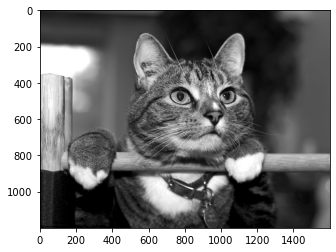

In [10]:
plt.figure()
plt.imshow(image)

Now, we calculate the number of elements (bytes in this case) in our image.

In [11]:
data_buffer_size=image.shape[0]*image.shape[1]*image.shape[2]
print(data_buffer_size)

5760000


Then, we create an instance of Shared Array object (who contains a lock property and get_lock() element). We need to know the C data type (in order to know how many bytes uses the single data type and the length of the linear array)

In [12]:
shared_space= Array(ctypes.c_byte,data_buffer_size)

Because the use of a Matrix as a linear vector could be hard to understand and visualize, we could create a new variable of type NumPy vector and set to use the prelocated memory space.<br/>

Once we create that NumPy variable, we can reshape this variable to see like a 3 dimensional vector (tensor)

In [13]:
shared_data=my.tonumpyarray(shared_space)
result_matrix=shared_data.reshape(image.shape)

In [14]:
image.shape

(1200, 1600, 3)

In [15]:
result_matrix.shape

(1200, 1600, 3)

In [16]:
my_filter=np.ones((3,3),dtype=np.uint8)

This first example, we will copy in the shared space the original image, in parallel.<br/>

In this case, we do not have memory hazzards (in theory), because we never tries to access at the same row from different parallel processes.

In [17]:
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.pool_init,initargs=[shared_space,image,my_filter]) as p:
    p.map(my.parallel_shared_imagecopy,rows)

The difference with the previous session code, is: we are not returning the filtered row data, and construct the final image. We are writing in a shared memory 

In [18]:
print(type(shared_data))

<class 'numpy.ndarray'>


In [19]:
print(result_matrix.shape)

(1200, 1600, 3)


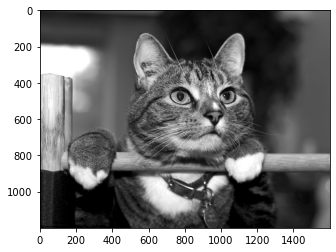

In [20]:
plt.figure()
plt.imshow(result_matrix)

## Shared memory assignment

In the myfunctions module, we have the function: edge_filter, which get a filter, and apply it to the image, writing the filtered row in to the shared r/w memory.
Check the code implementation, and modify it. Analyze the code. Which error we have? Check the order of instructions. It is efficent?

Implements several edge filters, like the described in https://en.wikipedia.org/wiki/Edge_detection

In [25]:
#This is the diferential second order differential edge filter
my_filter=np.zeros((3,3))
my_filter[0,0]=-0.25
my_filter[0,2]=0.25
my_filter[2,0]=0.25
my_filter[2,2]=-0.25
print(my_filter)

[[-0.25  0.    0.25]
 [ 0.    0.    0.  ]
 [ 0.25  0.   -0.25]]


In [26]:
rows=range(image.shape[0])
with mp.Pool(processes=NUMCORES,initializer=my.pool_init,initargs=[shared_space,image,my_filter]) as p:
    p.map(my.edge_filter,rows)

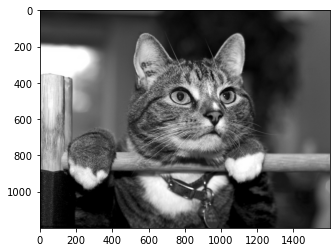

In [27]:
plt.figure()
plt.imshow(result_matrix)